In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import random
import math
from numba import njit

In [2]:
## the model input neighbour list, idx, probability, time, the previous infections, parameters, population size 
## the model output for kth ensemble, the county everytime
## it iterates every time
# @njit
def superspreading_T_Loc(T,num_fips,initials,weights_n,pop,paras,WN):
    Z, Zb, D, Db = paras
    ## initialise 
    l0, i0 = initials
    
    NewInf = np.zeros((num_fips,T*10))
    TotInf = np.zeros((num_fips,T*10))
    
    NewInf[l0,0] = i0
    TotInf[:,0] = NewInf[:,0]
    ### for each time step and each location
    for ti in range(T):
        print(ti)
        for l in range(num_fips):
            infectors = int(NewInf[l,ti])
            ### the number of possible new infections the size = 100 can infect individually from the NB 
            z_all = np.random.choice(len(weights_n), size = infectors, p=weights_n) ## this is a vector
            ### however, the populations have immunited people, the number will decrease i did not agree with this part 
            ## as the infection happens inside the location of the infectious people, for immunity is the pop of the 
            z_immunity = np.round(z_all*(1-TotInf[l,ti]/pop[l]))
            
            z_num = np.int64(np.sum(z_immunity))
            NF_l = np.zeros((2,z_num),dtype=np.int64)
            ## for the time distribution
            latency_p = SSA.gamma.rvs(a = Z,scale=Zb,size = z_num)
            infectious_p = SSA.gamma.rvs(a = D,scale=Db,size = z_num)
            v = np.random.random_sample(z_num)
            delay_days = latency_p+v*infectious_p

            NF_l[0,:] = np.ceil(delay_days+ti) ## make it idx int
            ## for the location distribution
            loc_idx = np.random.choice(np.arange(num_fips), size = z_num, p=WN[:,l])
            NF_l[1,:] = loc_idx

            ## infections merge into the matrix
            NewInf_l = np.zeros_like(NewInf)
            for i in range(z_num):
                t_i, loc_i = NF_l[:,i]
                NewInf_l[loc_i,t_i] = NewInf_l[loc_i,t_i]+1
            NewInf = NewInf + NewInf_l
            TotInf = np.cumsum(NewInf,axis=1)
    return NewInf, TotInf

In [3]:
WN = np.loadtxt('W_avg.csv')
Cave = np.loadtxt('Cave.csv')
pop = np.loadtxt('pop_new.csv')

In [4]:
num_fips = len(pop)
T = 60
num_ens = 300

In [5]:
Z = 3 # latent period
Zb = 1 # scale parameter for Z
D = 5 # infectious period
Db = 1 # scale parameter for b
alpha = 0.1 # reporting rate 10%

In [6]:
# seeding
l0 = 1859-1 # start with New York County NY in python -1, in matlab is 1895
i0 = 100 ## the starting t=0, in matlab it is 1
initials = (l0,i0)

In [7]:
x_cutoff = 100
r = 5 ## parameters (in the paper of Lloyd smith is the k)
R0 = 2.5  ## the model input

p = r/(R0+r)

weights = np.zeros(x_cutoff)
for i in range(x_cutoff):
    temp1=SS.gamma(r+i)/SS.gamma(r)/SS.gamma((i+1))*np.power(p,r)*np.power((1-p),i)
    weights[i] = temp1

In [8]:
print('it covers', np.sum(weights)*100,'% of the values') ## to generate the sample, the sum up probe should be 1
## we can assign/compare the rest of prob to each one
prob_res = (1- np.sum(weights))/x_cutoff
print (prob_res, 'compare with the last prob', weights[-1])
## normalise the weights to 1
weights_n = weights/np.sum(weights)

it covers 100.0 % of the values
0.0 compare with the last prob 3.3891205435755526e-42


In [10]:
%%time
NewInf, TotInf = superspreading_T_Loc(60,num_fips,(l0,i0),weights_n,pop,(3,1,5,1),WN)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
CPU times: user 24min 59s, sys: 7.82 s, total: 25min 7s
Wall time: 25min 9s


In [14]:
# NewInf_s = NewInf[:,:60]
NewInf1 = np.loadtxt('NewInf_r_0.1.csv')
NewInf_s1 = NewInf1[:,:60]
NewInf_s2 = NewInf[:,:60]

In [15]:
daily_per_pop1 = NewInf_s1/pop[:,None]*100000

# daily_per_pop2 = NewInf_s2/pop[:,None]*100000

Text(0, 0.5, 'counties with daily infections per 100000>10')

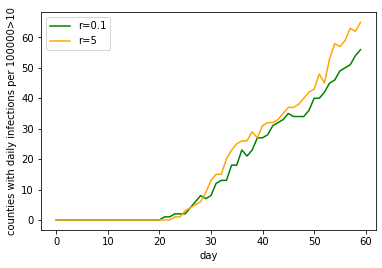

In [16]:
plt.plot(np.sum(daily_per_pop1>10,axis=0),label='r=0.1',color='green')
plt.plot(np.sum(daily_per_pop2>10,axis=0),label='r=5',color='orange')
plt.legend()
plt.xlabel('day')
plt.ylabel('counties with daily infections per 100000>10')

In [61]:
# np.savetxt('NewInf_r_0.1.csv',NewInf)
np.savetxt('NewInf_r_51.csv',NewInf)